# Lab 1: Segmentacion

Debe formar grupo de hasta 3 personas para los laboratorios.

__Estudiante 1:__ Leonardo Achá Boiano \
__Estudiante 2:__ Bruno Ramiro Rejas Montero \
__Estudiante 3:__ Matias Adorno Mazzocato

__Fecha de inicio:__ 2 de Marzo del 2023 \
__Fecha de entrega:__ 20 de Marzo del 2023 (11:59 pm)

## Importante

El objetivo de los laboratorios es mostrar la implementación práctica de los temas presentados durante la clase, así como preparar los para el proyecto final, que es un proyecto práctico que une los temas del curso.

Como tal, en los  laboratorios/proyecto final, a menos que se especifique lo contrario, debe utilizar funciones de procesamiento de imágenes/libraries como ser `opencv` y `sklearn`. 

Sin embargo, por cada funcion utilizada se debe dar una explicación suficiente en el informe de laboratorio. Note que no se necesita implementar un detector de bordes propio, etc.

Por otro lado, existen algunas funciones, algoritmos, que no estan presentes en `opencv` como por ejemplo `region growing`. Como ya se menciono, no se quiere que lo implementen desde cero si no que busquen en otras librerias para utilizar dicho algoritmo. Una libreria que se usa en conjunto con `opencv` es `sklearn` (Note que puede realizar el laboratorio utilizando solamente una libreria pero si lo desea puede usar ambas). 

Para instalar la libreria scikit-image corra el siguiente comando ([scikit-image](https://scikit-image.org/docs/stable/install.html#install-via-pip)):

```bash
python -m pip install -U scikit-image
```


A continuacion, se muestra algunas funciones de `scikit-image` que le podria ser de utilidad:

- skimage.exposure.is_low_contrast
- exposure.rescale_intensity
- skimage.measure.label
- skimage.color.label2rgb
- skimage.measure.regionprops
- scipy.ndimage.gaussian_laplace (OpenCV tambien permite realizar el LOG)

Entre otros metodos. Revise la documentacion.

Note que debe guardar todos los experimentos posibles para documentar la elaboracion del laboratorio.

**Antes de entregar la notebook <font color='red'> rerun </font>la notebook from scratch !**
`Kernel` > `Restart & Run All`

## Extraer la Data

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.getcwd(), 'images')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Parte 1: Segmentacion

__Objetivo:__ calcular el tamaño del cerebro (sin el cráneo) en píxeles en una imagen 2D de una cabeza humana tomada por Imágenes por resonancia magnética (MRI) mediante:

* Region growing (5 pts)
* Detección de contornos (5 pts)
    - LOG
    - Sobel
    - Canny 

Cada sección debe mostrar la segmentación resultante, así como el tamaño en píxeles de la región detectada. Tambien, debe realizar comentarios, limitaciones y/o ventajas de cada método.

Analice sus resultados, pruebe todas las formas posibles (mientras mas mejor). Nuevamente, no se rompera nada si probamos varios metodos. Recuerde siempre hacer una copia original de la imagen.


__Importante__
Guardar la imagen en con la cantidad de pixeles en cada iteracion y comparar los resultados bajo distintos metodos.

## Visualizacion de la imagen

In [2]:
import skimage.io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

pd.set_option('display.max_rows', None)
%matplotlib inline

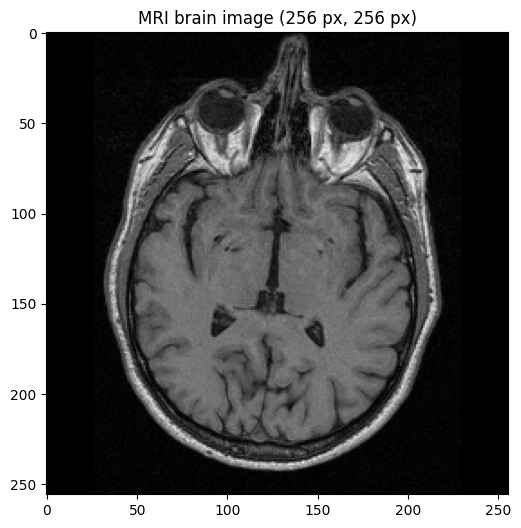

(256, 256)


In [4]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
brain_img=brain_im.copy()

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title(f'MRI brain image ({im_h} px, {im_w} px)')
ax.axis('on')
plt.show()
print(brain_img.shape)

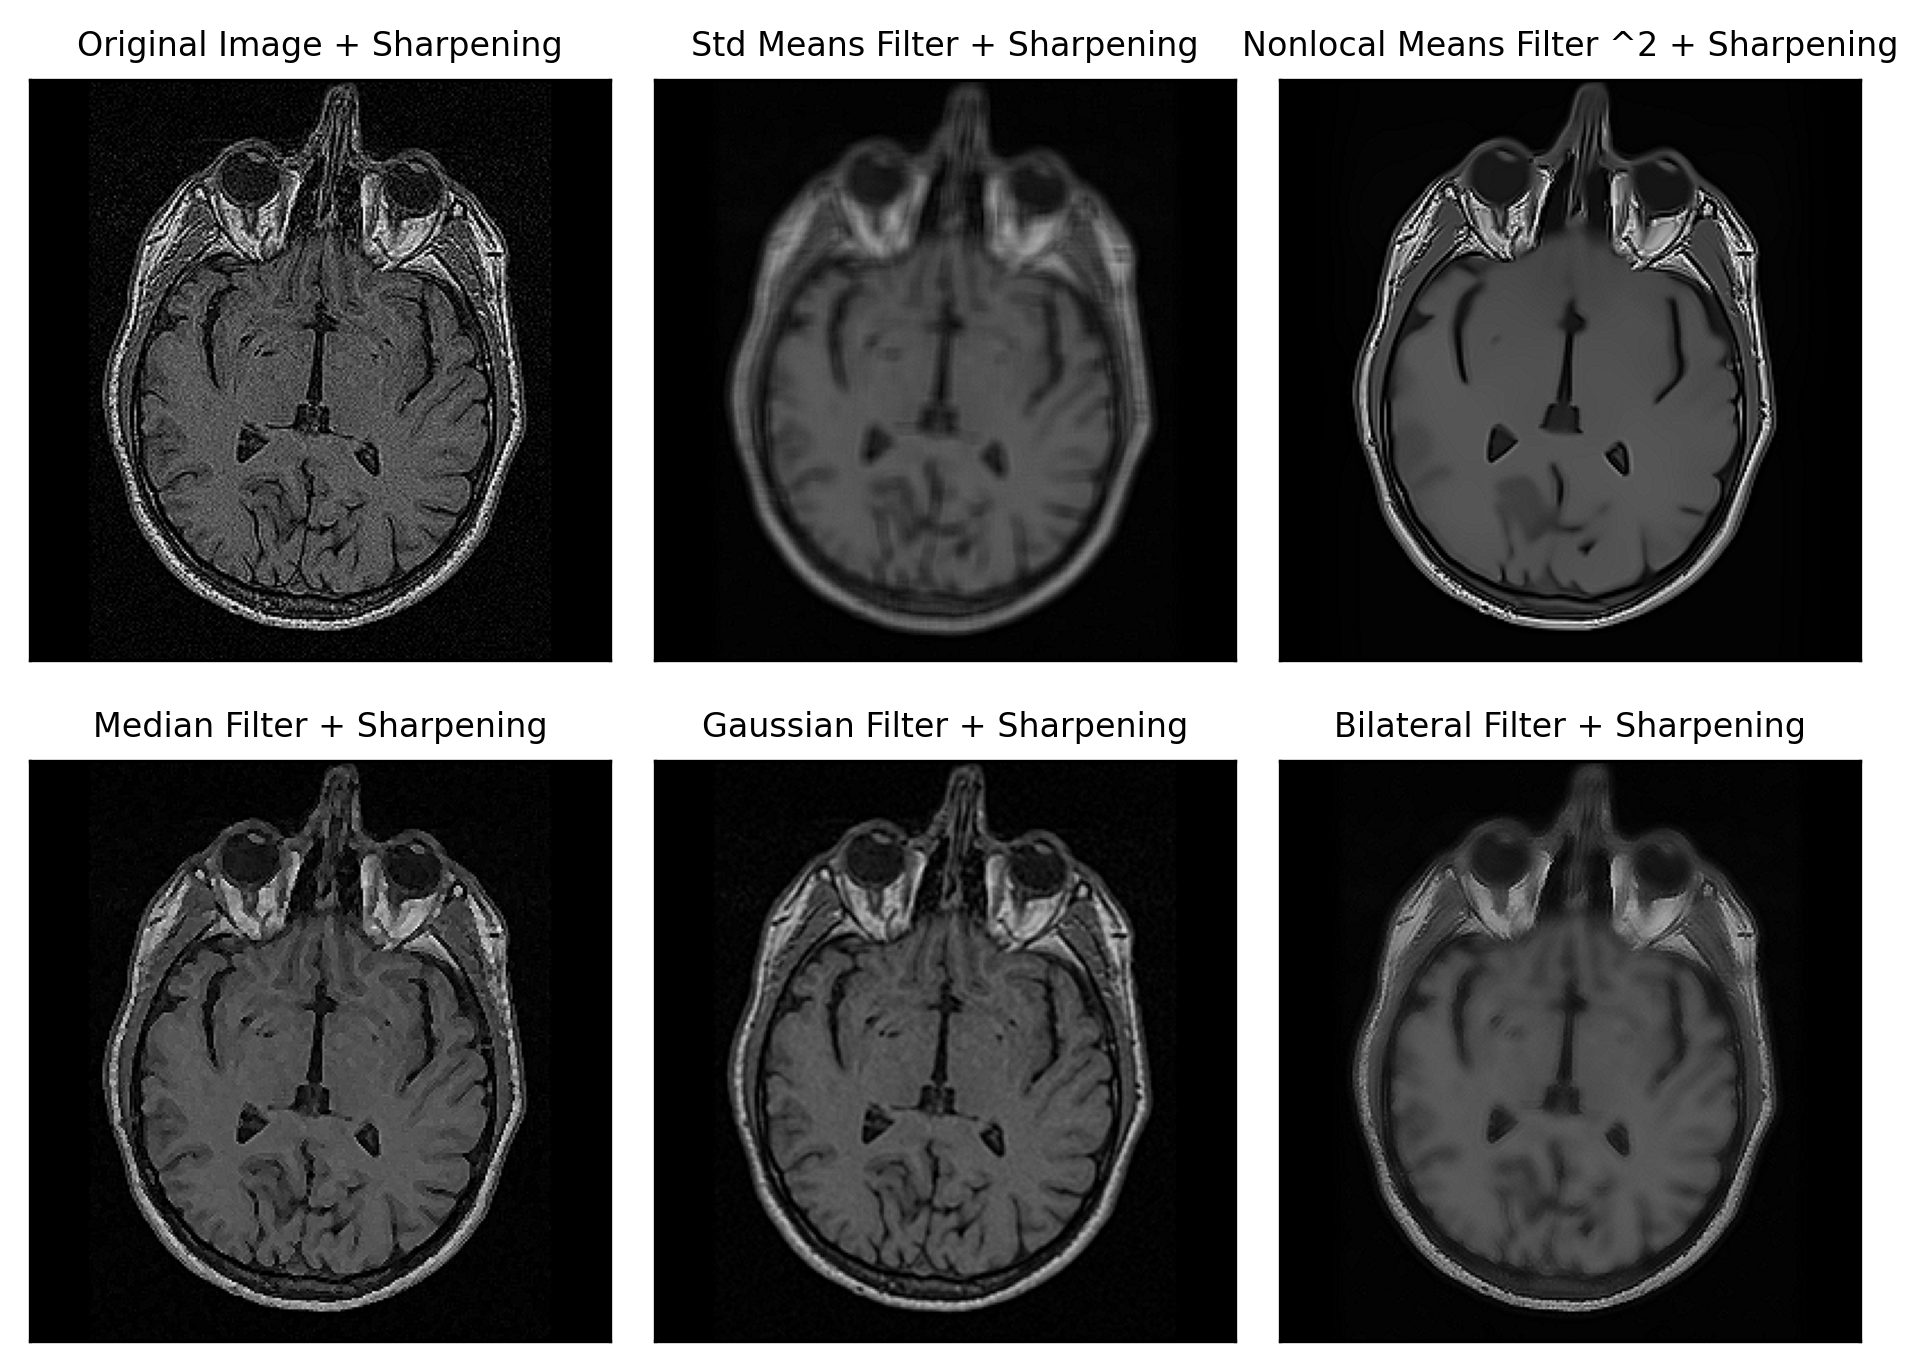

In [8]:
#image filtering
filters_str=['Original Image','Std Means Filter',
             'Nonlocal Means Filter ^2','Median Filter',
             'Gaussian Filter', 'Bilateral Filter']
images=[brain_img]
filter_size=6
low_pass_kernel=np.ones((filter_size,filter_size),np.float32)/filter_size**2
images.append(cv2.filter2D(src=brain_img, 
                           ddepth=-1, kernel=low_pass_kernel)) #standart mean filter
images.append(cv2.fastNlMeansDenoising(brain_img, 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10)) #Nonlocal means denoising algorithm
images[2]=cv2.fastNlMeansDenoising(images[2], 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10) #Nonlocal means denoising algorithm
images.append(cv2.medianBlur(brain_img, 3))
images.append(cv2.GaussianBlur(brain_img,(3,3),0)) #gaussian filter
images.append(cv2.bilateralFilter(brain_img, 9,60,60)) #bilateral filter

sharpen_kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
for i in range(len(images)):
    images[i]=sharpenOutput=cv2.filter2D(src=images[i], ddepth=-1, kernel=sharpen_kernel)

fig=plt.figure(dpi=300)
for i in range(len(images)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(f"{filters_str[i]} + Sharpening", fontsize=8)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()


## 1.1 Region growing (5 pts)

Region growing is an iterative method used to extract similar parts of an image. One or several points are chosen as a start. The region then grows until it is finally blocked by the stop criteria. This criteria is generally an inside/outside region comparison (energy, size, . . .).  

In [9]:
# YOU CODE HERE AND DISCUSSION
def region_growing(img, seed, tolerance=0.1, color=255):
    """
    Segment an image using region growing.
    
    Args:
        img (np.ndarray): The input image.
        seed (tuple): The pixel coordinates (x, y) of the seed point.
        tolerance (float): Allowed difference between seed value and neighborhood
        color (int) = mask color
    
    Returns:
        np.ndarray: The segmented image mask.
    """
    # Initialize segmented image with zeros
    segmented = np.zeros_like(img) #Estable una matriz 0 para poner la imagen de entrada
    #el mismo tamaño y tipo de dato
    
    # Initialize queue with seed point
    queue = [seed] #Incluye coodenadas x,y para el Region Growing
    
    # Get seed point color
    seed_color = img[seed]
    
    # Loop until the queue is empty
    while queue:
        # Get next pixel from queue
        pixel = queue.pop(0)
        
        # Check if pixel is within image bounds
        if (0 <= pixel[0] < img.shape[0]) and (0 <= pixel[1] < img.shape[1]):
            # Check if pixel is unsegmented and similar to seed color
            if segmented[pixel[0], pixel[1]] == 0 and np.allclose(img[pixel], seed_color, rtol=tolerance, atol=tolerance):
                # Segment pixel
                segmented[pixel[0], pixel[1]] = color
                
                # Add neighboring pixels to queue
                queue.append((pixel[0] - 1, pixel[1]))
                queue.append((pixel[0] + 1, pixel[1]))
                queue.append((pixel[0], pixel[1] - 1))
                queue.append((pixel[0], pixel[1] + 1))
    
    return segmented


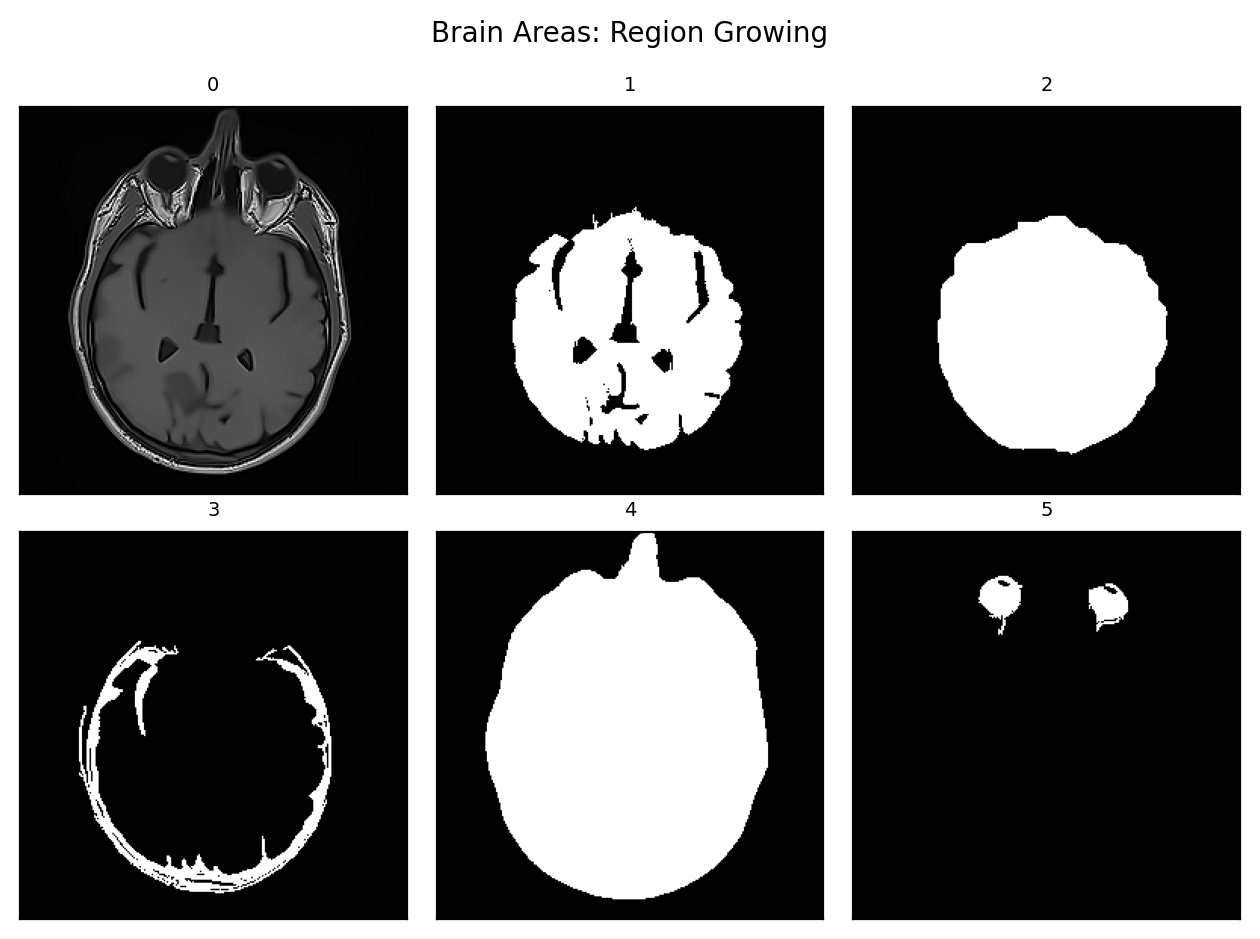

In [13]:
brain_areas=[images[2]]

# Apply region growing segmentation
brain_areas.append(region_growing(images[2], (100, 100), 0.23))
brain_areas.append(cv2.morphologyEx(brain_areas[1], cv2.MORPH_CLOSE, 
                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)),
                    iterations=6))
brain_areas.append(region_growing(images[2], (175, 50), 0.99))
brain_areas.append(cv2.bitwise_not(region_growing(images[2], (50, 250), 10)))
brain_areas.append(region_growing(images[2], (50, 100), 1)+region_growing(images[2], (50, 175), 1))

# Display results
fig=plt.figure(dpi=200)
for i in range(len(brain_areas)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(brain_areas[i],'gray',vmin=0,vmax=255)
    plt.title(i, fontsize=7)
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
fig.suptitle('Brain Areas: Region Growing', fontsize=10)
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig("results/Ex1.1-Brain-Areas-Region-Growing.png",bbox_inches='tight')

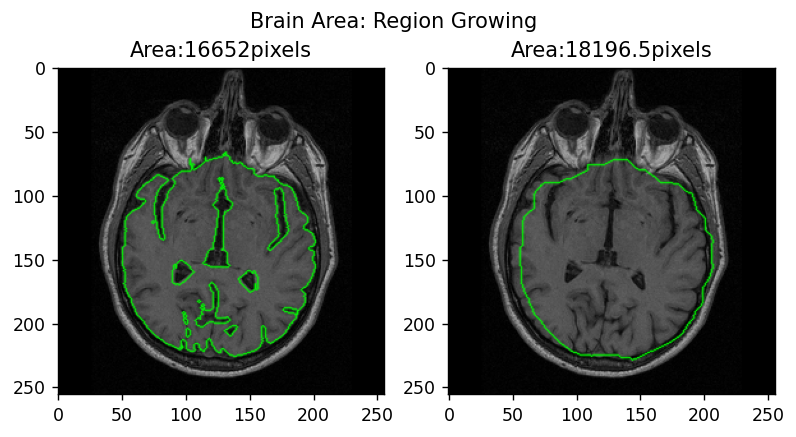

In [14]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=brain_areas[1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
cv2.drawContours(image=image_copy, contours=contour, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
title_1=f'Area:{np.count_nonzero(brain_areas[1] == 255)}pixels'

contour, hierarchy = cv2.findContours(image=brain_areas[2], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_copy_2 = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
cv2.drawContours(image=image_copy_2, contours=contour, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
title_2=f'Area:{cv2.contourArea(contour[0])}pixels'

fig=plt.figure(dpi=125)
plt.suptitle('Brain Area: Region Growing')
plt.subplot(121)
plt.title(title_1)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.subplot(122)
plt.title(title_2)
plt.imshow(image_copy_2,'gray',vmin=0,vmax=255)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
fig.savefig("results/Ex1.1-Brain-Area-Region-Growing.png",bbox_inches='tight')

In [8]:
print(f"El area del cerebro está en el rango de {np.count_nonzero(brain_areas[1] == 255)} a {np.count_nonzero(brain_areas[2] == 255)} pixeles.") #Otra forma de contar los pixeles

El area del cerebro está en el rango de 16652 a 18424 pixeles.


## 1.2 Contour detection (5 pts)

In [15]:
#apply mask of brain_areas[4] to images[2] in order to eliminate any background noise befour contour detection
images[2][brain_areas[4]<255]=0
#Equalizate histogram -> Add contrast to image
brain_eq_hist=cv2.equalizeHist(images[2].copy())

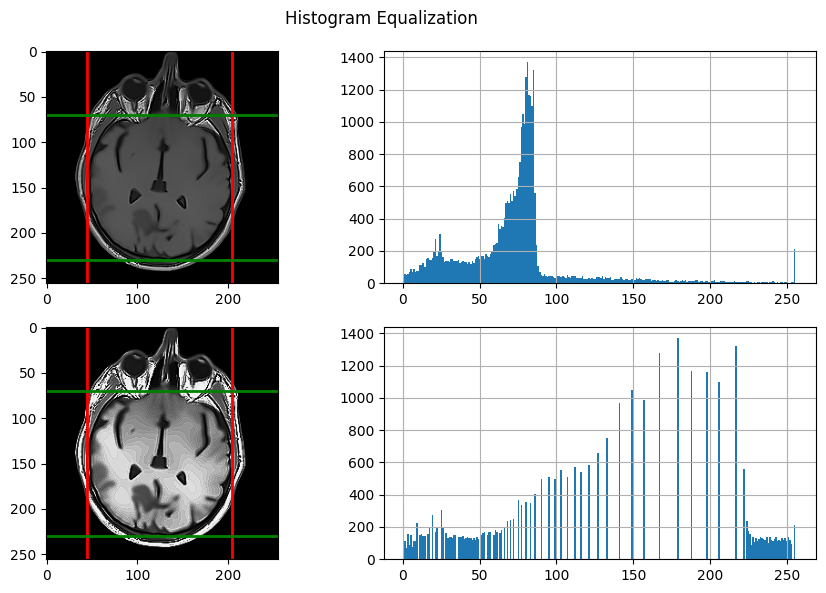

In [16]:
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.imshow(images[2],'gray',vmin=0,vmax=255)
plt.axvline(45, color='r', linewidth=2)
plt.axvline(205, color='r', linewidth=2)
plt.axhline(70, color='g', linewidth=2)
plt.axhline(230, color='g', linewidth=2)
plt.subplot(2,2,2)
plt.hist(images[2].ravel(),256,[1,256])
plt.grid()
plt.subplot(2,2,3)
plt.imshow(brain_eq_hist,'gray',vmin=0,vmax=255)
plt.axvline(45, color='r', linewidth=2)
plt.axvline(205, color='r', linewidth=2)
plt.axhline(70, color='g', linewidth=2)
plt.axhline(230, color='g', linewidth=2)
plt.subplot(2,2,4)
plt.hist(brain_eq_hist.ravel(),256,[1,256])
plt.grid()

plt.suptitle('Histogram Equalization')
plt.tight_layout()
plt.show()

[**[Operador Laplaciano de la Gaussiana (LoG)](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm#:~:text=The%20LoG%20operator%20calculates%20the,LoG%20response%20will%20be%20zero.)**  
El Laplaciano L(x,y) de una imagen con valores de intensidad de píxel I(x,y) se define como:  
$$L(x, y)=\frac{\partial^2 I}{\partial x^2}+\frac{\partial^2 I}{\partial y^2}$$  
Utilizando uno de estos núcleos, el Laplaciano puede calcularse mediante métodos convolucionales estándar:   
$$
\begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0
\end{bmatrix};
\begin{bmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{bmatrix}
$$  
Dado que estos núcleos aproximan una medida de segunda derivada sobre la imagen, son muy sensibles al ruido. Para contrarrestar esto, la imagen se suele suavizar mediante un filtro gaussiano antes de aplicar el filtro Laplaciano. Este paso de preprocesamiento reduce los componentes de ruido de alta frecuencia antes del paso de diferenciación.
De hecho, dado que la operación de convolución es asociativa, podemos convolucionar el filtro de suavizado gaussiano con el filtro Laplaciano primero, y luego convolucionar este filtro híbrido con la imagen para obtener el resultado deseado. Hacerlo de esta manera tiene dos ventajas:
* Dado que tanto el filtro gaussiano como el filtro Laplaciano suelen ser mucho más pequeños que la imagen, este método generalmente requiere muchas menos operaciones aritméticas.
* El núcleo LoG ('Laplacian of Gaussian') puede calcularse de antemano, por lo que solo se necesita realizar una convolución en tiempo de ejecución en la imagen.

El operador LoG calcula la segunda derivada espacial de una imagen. Esto significa que en áreas donde la imagen tiene una intensidad constante (es decir, donde el gradiente de intensidad es cero), la respuesta LoG será cero.  
En la cercanía de un cambio en la intensidad, sin embargo, la respuesta LoG será positiva en el lado más oscuro y negativa en el lado más claro. Esto significa que en un borde razonablemente marcado entre dos regiones de intensidades uniformes pero diferentes, la respuesta LoG será:  
* cero a una larga distancia del borde,
* positiva a un lado del borde,
* negativa al otro lado del borde,
* cero en algún punto intermedio, en el propio borde.  
]

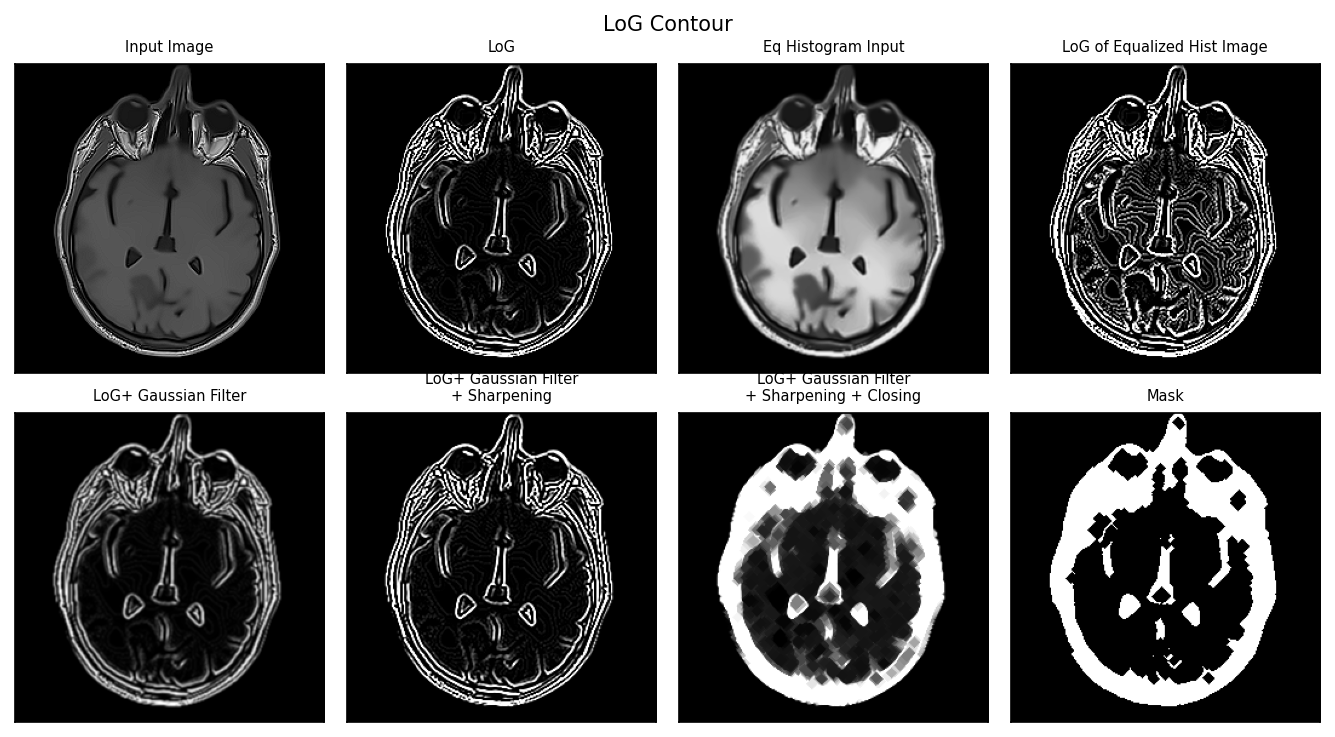

In [20]:
# LoG
gauss = np.array([[1,2,1],[2,4,2],[1,2,1]])
laplacian = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

LoG=signal.convolve2d(laplacian, gauss)

brain_LoG=[images[2]]
brain_LoG_str=['Input Image']
brain_LoG.append(cv2.filter2D(src=images[2], ddepth=-1, kernel=LoG))
brain_LoG_str.append('LoG')

brain_LoG.append(cv2.GaussianBlur(cv2.fastNlMeansDenoising(brain_eq_hist, 
                                        templateWindowSize=7,
                                        searchWindowSize=21,
                                        h=10),(3,3),0))
brain_LoG_str.append('Eq Histogram Input')
brain_LoG.append(cv2.filter2D(src=brain_eq_hist, ddepth=-1, kernel=LoG))
brain_LoG_str.append('LoG of Equalized Hist Image')

#Apply Gaussian Filter
brain_LoG.append(cv2.GaussianBlur(brain_LoG[1],(3,3),0))
brain_LoG_str.append(f'{brain_LoG_str[1]}+ Gaussian Filter')

#Apply sharpening
brain_LoG.append(cv2.filter2D(src=brain_LoG[-1], ddepth=-1, kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])))
brain_LoG_str.append(f'{brain_LoG_str[-1]}\n+ Sharpening')

#Apply Closing
brain_LoG.append(cv2.dilate(brain_LoG[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=4))
brain_LoG[-1]=cv2.erode(brain_LoG[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=4)
brain_LoG_str.append(f'{brain_LoG_str[-1]} + Closing')

#Get Mask
brain_LoG.append(cv2.bitwise_not(cv2.inRange(brain_LoG[-1], 0, 110)))
brain_LoG_str.append('Mask')

# Display results
fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(brain_LoG)):
    fig.add_subplot(2,4,i+1)
    plt.imshow(brain_LoG[i],'gray',vmin=0,vmax=255)
    plt.title(brain_LoG_str[i], fontsize=7)
    plt.xticks([]),plt.yticks([])
fig.suptitle('LoG Contour', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
fig.savefig("results/Ex1.2-Brain-Area-LoG-Process.png",bbox_inches='tight')


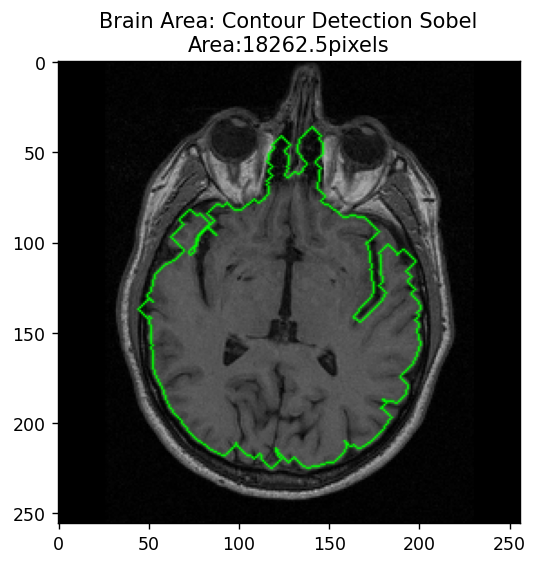

In [21]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=brain_LoG[-1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
fig=plt.figure(dpi=125)
cv2.drawContours(image=image_copy, contours=contour[3:4], contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.title(f'Brain Area: Contour Detection Sobel\nArea:{cv2.contourArea(contour[3])}pixels')
fig.savefig("results/Ex1.2-Brain-Area-LoG.png",bbox_inches='tight')


Acoording to opencv's [documentation](https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html):  
**Sobel Operator**  
1. The Sobel Operator is a discrete differentiation operator. It computes an approximation of the gradient of an image intensity function.  
2. The Sobel Operator combines Gaussian smoothing and differentiation.  
**Formulation**   
Assuming that the image to be operated is I:  
1. We calculate two derivatives:  
a. Horizontal changes: This is computed by convolving I with a kernel Gx with odd size. For example for a kernel size of 3, Gx would be computed as:    
$$ G_x=\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1
\end{bmatrix}*I$$  
b. Vertical changes: This is computed by convolving I with a kernel Gy with odd size. For example for a kernel size of 3, Gy would be computed as:   
$$ G_x=\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
+1 & +2 & +1
\end{bmatrix}*I$$  
2. At each point of the image we calculate an approximation of the gradient in that point by combining both results above:   
$$G=\sqrt{G_x^2+G_y^2}$$
Although sometimes the following simpler equation is used:   
$$G=|G_x|+|G_y|$$



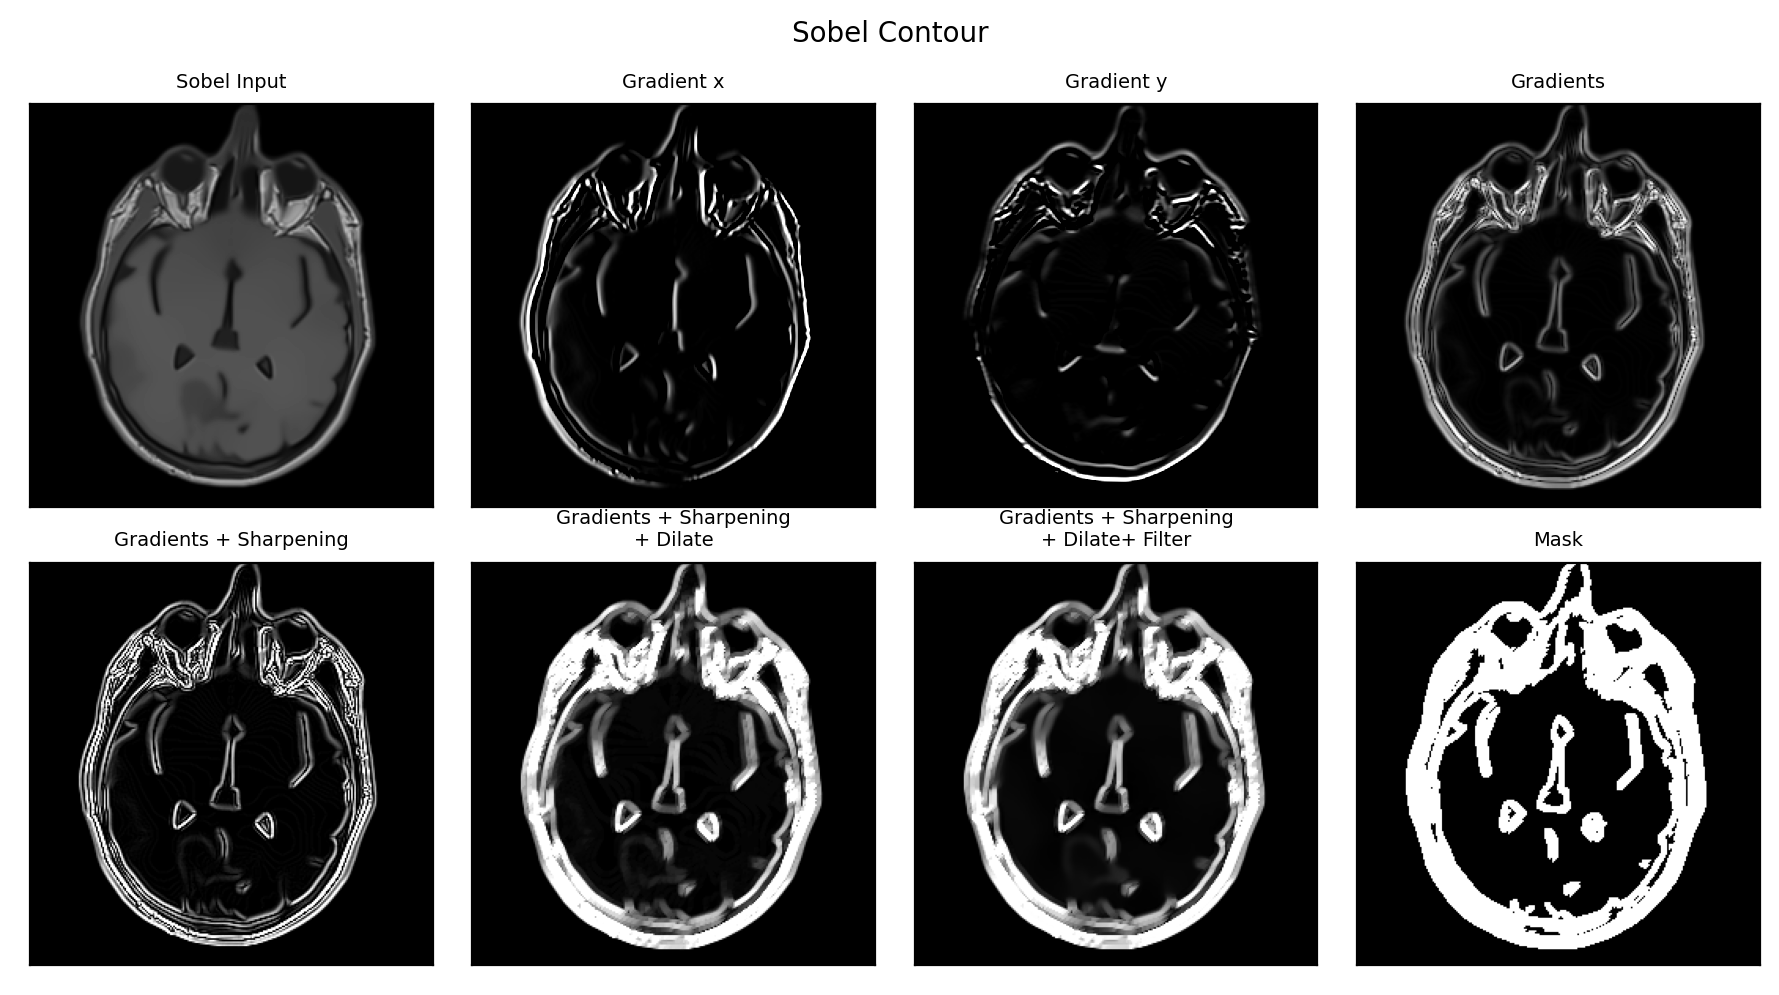

In [13]:
#SOBEL
scale = 1
delta = 0
ddepth = cv2.CV_16S

#image preprocessing for sobel edge detection
sobel_input=cv2.GaussianBlur(images[2],(3,3),0).copy() #Gaussian filter
#sobel_input=cv2.filter2D(src=images[2], ddepth=-1, kernel=np.array([[1,2,1],[2,4,2],[1,2,1]])*1/16).copy() #Averaging filter
sobel_input=cv2.fastNlMeansDenoising(sobel_input, templateWindowSize=7,searchWindowSize=21, h=10).copy()

grad_x = cv2.Sobel(sobel_input, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
grad_y = cv2.Sobel(sobel_input, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
#General Gradient
grad = cv2.addWeighted(cv2.convertScaleAbs(grad_x), 0.5, cv2.convertScaleAbs(grad_y), 0.5, 0)

gradients=[sobel_input, grad_x, grad_y, grad]
gradients_str=['Sobel Input', 'Gradient x', 'Gradient y', 'Gradients'] #Subplots' titles

#Apply sharpening
gradients.append(cv2.filter2D(src=gradients[-1], ddepth=-1, kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])))
gradients_str.append(f'{gradients_str[-1]} + Sharpening')

#Apply morphological operation
#gradients.append(cv2.erode(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1))
#gradients.append(cv2.erode(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations=2))
#gradients_str.append(f'{gradients_str[-1]}\n+ Erode')

gradients.append(cv2.dilate(gradients[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations=2))
gradients_str.append(f'{gradients_str[-1]}\n+ Dilate')

#Apply Denoising Filter
gradients.append(cv2.fastNlMeansDenoising(gradients[-1], templateWindowSize=7,searchWindowSize=21, h=10))
gradients_str.append(f'{gradients_str[-1]}+ Filter')

#Get Mask
gradients.append(cv2.bitwise_not(cv2.inRange(gradients[-1], 0, 50)))
gradients_str.append('Mask')

# Display results
#fig=plt.figure(dpi=150)
fig=plt.figure(figsize=(9,5), dpi=200)
for i in range(len(gradients)):
    fig.add_subplot(2,4,i+1)
    plt.imshow(gradients[i],'gray',vmin=0,vmax=255)
    plt.title(gradients_str[i], fontsize=7)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Sobel Contour', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
fig.savefig("results/Ex1.2-Brain-Area-Sobel-Process.png",bbox_inches='tight')

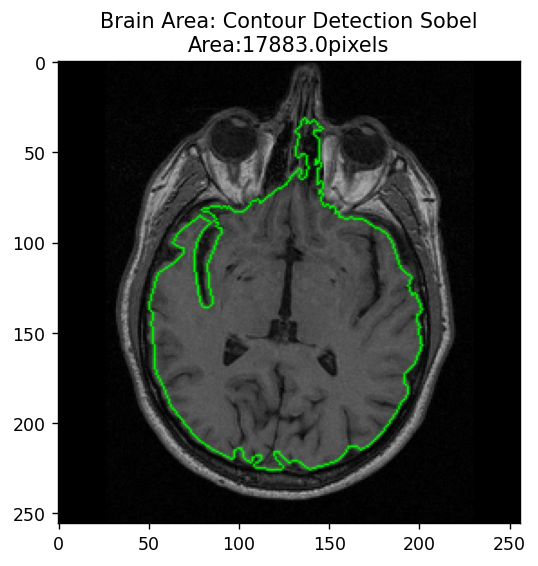

In [14]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=gradients[-1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
fig=plt.figure(dpi=125)
cv2.drawContours(image=image_copy, contours=contour[86:87], contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.title(f'Brain Area: Contour Detection Sobel\nArea:{cv2.contourArea(contour[86])}pixels')
fig.savefig("results/Ex1.2-Brain-Area-Sobel.png",bbox_inches='tight')

In [15]:
print(f'La tecnica de deteccion de contornos mediante el operador de Sobel indica que el area del cerebro es de {int(cv2.contourArea(contour[86]))} pixeles')

La tecnica de deteccion de contornos mediante el operador de Sobel indica que el area del cerebro es de 17883 pixeles


La [detección de bordes de Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) es un algoritmo popular de detección de bordes en múltiples etapas. Fue desarrollado por John F. Canny.

1. Reducción de ruido.
2. Cálculo del gradiente de intensidad de la imagen.
   La imagen suavizada se filtra con un núcleo Sobel en dirección horizontal y vertical para obtener la primera derivada en dirección horizontal (Gx) y en dirección vertical (Gy).
   $$ G=\sqrt{G_x^2+G_y^2}$$
   $$ \theta=tan^{-1}\frac{G_y}{G_x} $$

3. Supresión de no máximos.
   Después de obtener la magnitud y dirección del gradiente, se realiza un escaneo completo de la imagen para eliminar píxeles no deseados que no constituyen el borde. Para esto, en cada píxel se verifica si es un máximo local en su vecindario en la dirección del gradiente.

4. Umbralización por histéresis.
   En esta etapa se decide qué bordes son realmente bordes y cuáles no. Para ello, se necesitan dos valores de umbral, minVal y maxVal. Cualquier borde con un gradiente de intensidad mayor que maxVal es considerado un borde seguro, mientras que aquellos por debajo de minVal son considerados no bordes y se descartan. Aquellos que se encuentran entre estos dos umbrales se clasifican como bordes o no bordes en función de su conectividad. Si están conectados a píxeles de "borde seguro", se consideran parte de los bordes.

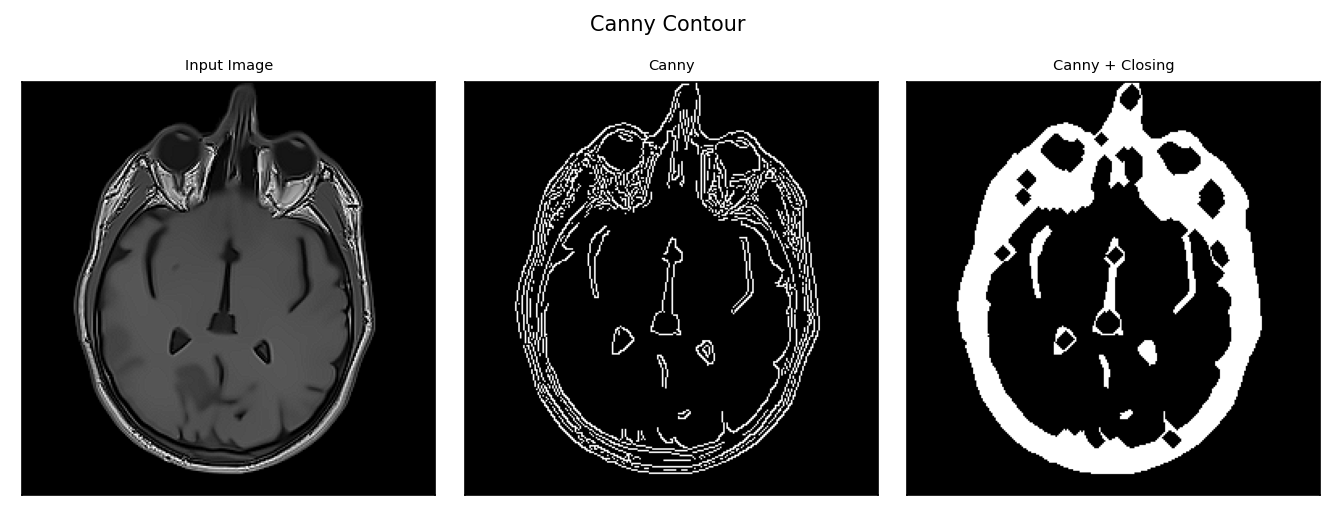

In [16]:
#CANNY
brain_canny=[images[2]]
brain_canny_str=['Input Image']
brain_canny.append(cv2.Canny(images[2],100,200))
brain_canny_str.append('Canny')

#Apply Closing
brain_canny.append(cv2.dilate(brain_canny[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=4))
brain_canny[-1]=cv2.erode(brain_canny[-1], cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=4)
brain_canny_str.append(f'{brain_canny_str[-1]} + Closing')

# Display results
fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(brain_canny)):
    fig.add_subplot(1,3,i+1)
    plt.imshow(brain_canny[i],'gray',vmin=0,vmax=255)
    plt.title(brain_canny_str[i], fontsize=7)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Canny Contour', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()
fig.savefig("results/Ex1.2-Brain-Area-Canny-Process.png",bbox_inches='tight')

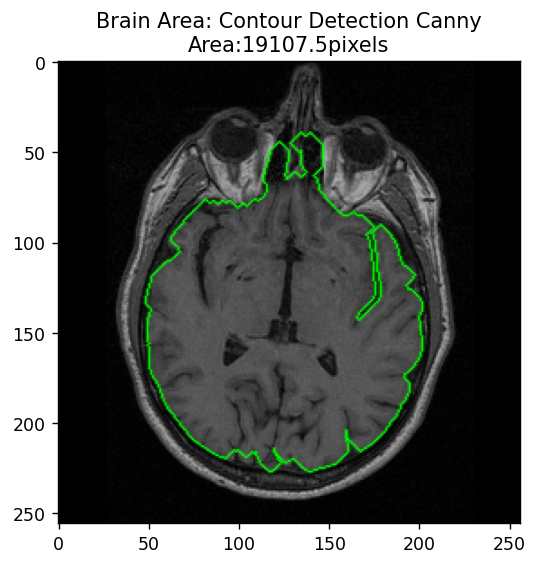

In [17]:
# detect the contours on the binary image
contour, hierarchy = cv2.findContours(image=brain_canny[-1], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image
image_copy = cv2.cvtColor(brain_img.copy(),cv2.COLOR_GRAY2BGR)
fig=plt.figure(dpi=125)
cv2.drawContours(image=image_copy, contours=contour[7:8], contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
plt.imshow(image_copy,'gray',vmin=0,vmax=255)
plt.title(f'Brain Area: Contour Detection Canny\nArea:{cv2.contourArea(contour[7])}pixels')
fig.savefig("results/Ex1.2-Brain-Area-Canny.png",bbox_inches='tight')

---
## Parte 2: Segmentacion Forma/Color 

A continuación encontrará tres fotografías tomadas bajo tres iluminaciones diferentes, que contienen algunas formas con diferentes colores. Se pide que se cree una funcion para:

1. Contar el número de formas de cada color (solo color no distinción entre formas) (5pts).
2. Calcular el área total (en píxeles) de cada color (5 pts).

Note que esta funcion debe detectar realizar los pasos anteriores bajo cualquier ilumniacion. Por esto, tenga en cuenta que un desafío específico es ser resistente a los cambios de iluminación. Por lo tanto, en algun tipo de intensidad probablemente se debería realizar la normalizacion.

__Sugerencia__: el espacio de color RGB podría no ser óptimo. Considere usar el espacio de color HSV o LAB.

## 2.1 Visualizacion

In [18]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]

images = []
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    
    if img is not None:
        images.append(img)
        

print(f'Number of images: {len(images)}')
print(f'Image size: {images[0].shape[:2]}')
print(f'Number of color channels: {images[0].shape[-1]}')

Number of images: 3
Image size: (480, 640)
Number of color channels: 3


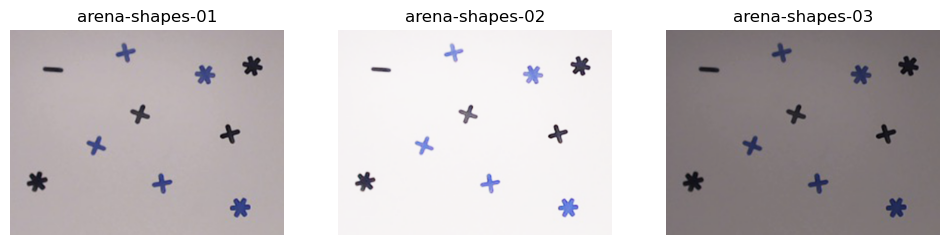

In [19]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(nm)
plt.show()

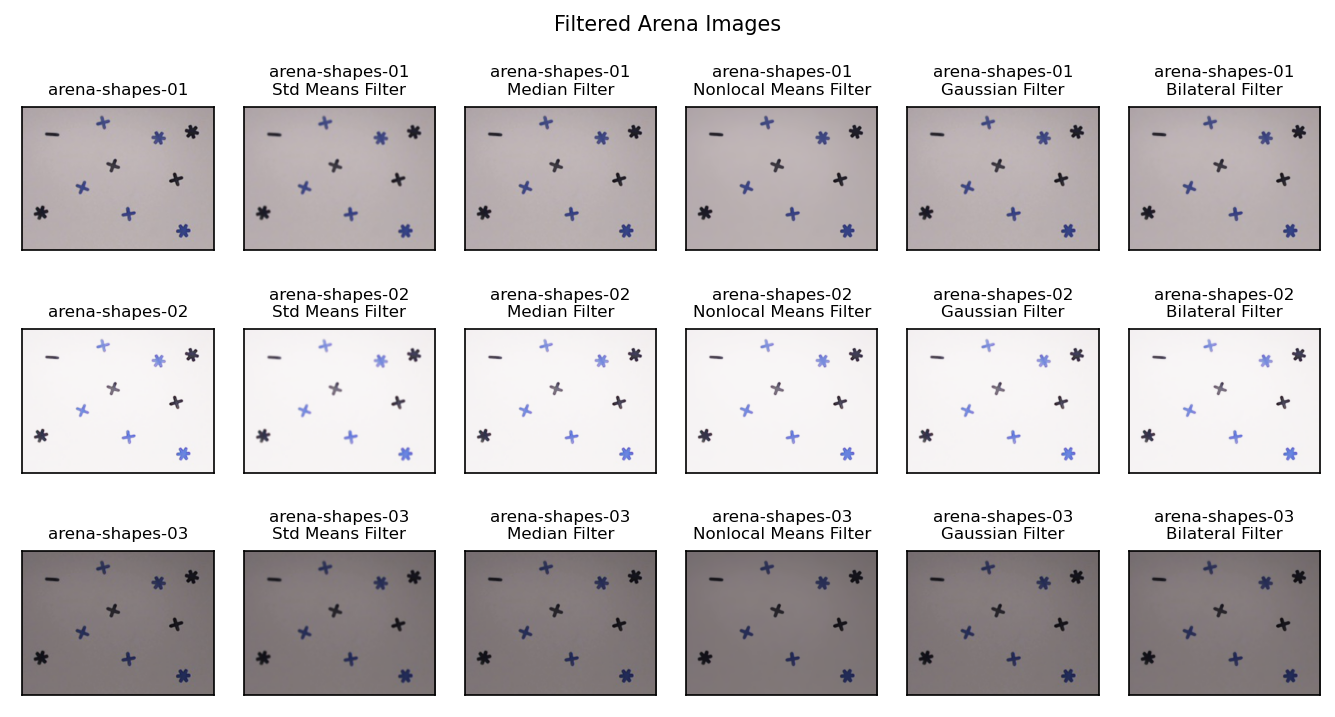

In [20]:
#image filtering
arena_images_str=[]
arena_images=[]
filter_size=6
low_pass_kernel=np.ones((filter_size,filter_size),np.float32)/filter_size**2

for i,image in enumerate(images):
    i+=1
    #imagen original 
    arena_images.append(image)
    title=f'arena-shapes-0{i}'
    arena_images_str.append(title)

    #standart mean filter
    arena_images.append(cv2.filter2D(src=image, ddepth=-1, kernel=low_pass_kernel)) 
    arena_images_str.append(f'{title}\nStd Means Filter')

    #median filter
    arena_images.append(cv2.medianBlur(image, 3))
    arena_images_str.append(f'{title}\nMedian Filter')

    #Nonlocal means denoising algorithm
    arena_images.append(cv2.fastNlMeansDenoising(image,  templateWindowSize=7, searchWindowSize=21, h=10)) 
    arena_images_str.append(f'{title}\nNonlocal Means Filter')

    #gaussian filter
    arena_images.append(cv2.GaussianBlur(image,(3,3),0)) 
    arena_images_str.append(f'{title}\nGaussian Filter')

    #bilateral filter
    arena_images.append(cv2.bilateralFilter(image, 9,60,60)) 
    arena_images_str.append(f'{title}\nBilateral Filter')

fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(arena_images)):
    fig.add_subplot(3,6,i+1)
    plt.imshow(cv2.cvtColor(arena_images[i], cv2.COLOR_BGR2RGB),'gray',vmin=0,vmax=255)
    plt.title(arena_images_str[i], fontsize=8)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Filtered Arena Images', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.savefig("results/Ex2.1-Filtered-Arena-Iamges.png",bbox_inches='tight')
plt.show()

No se observa diferencia apreciable entre diferentes filtros para esta imagen.

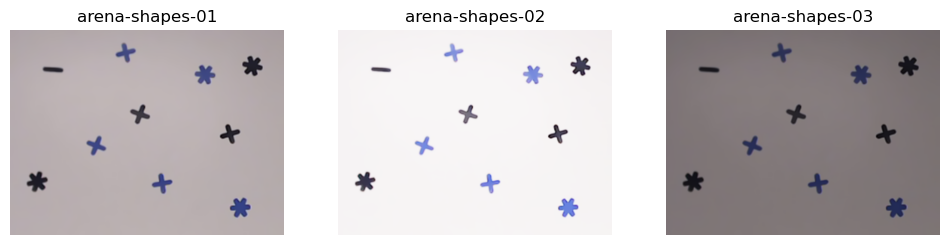

In [21]:
images=[arena_images[3], arena_images[9], arena_images[15]]
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(nm)
plt.show()

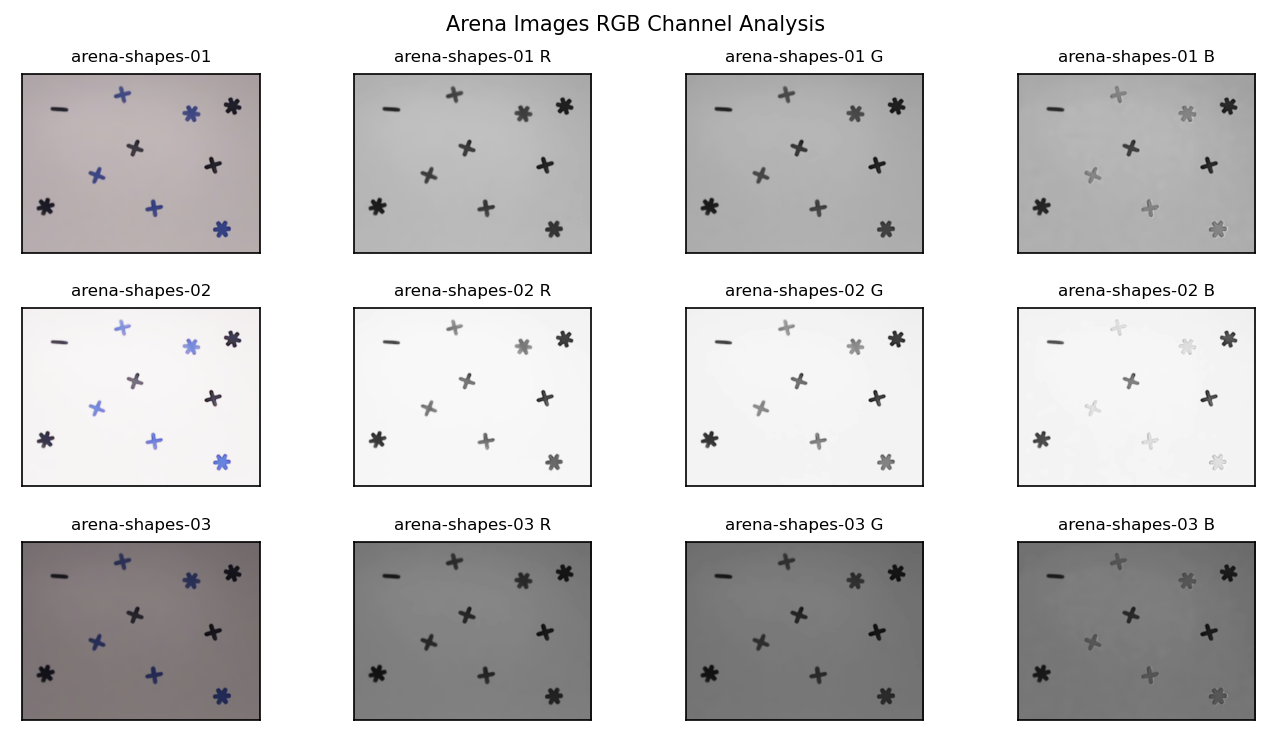

In [22]:
#Imagen original Seguida de un canal
arena_images_rgb_str=[]
arena_images_rgb=[]

for image, im_name in zip(images, im_names):
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    arena_images_rgb.append(image)
    arena_images_rgb_str.append(im_name)
    arena_images_rgb.append(image[:,:,0])
    arena_images_rgb_str.append(f"{im_name} R")
    arena_images_rgb.append(image[:,:,1])
    arena_images_rgb_str.append(f"{im_name} G")
    arena_images_rgb.append(image[:,:,2])
    arena_images_rgb_str.append(f"{im_name} B")


fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(arena_images_rgb)):
    fig.add_subplot(3,4,i+1)
    plt.imshow(arena_images_rgb[i],'gray',vmin=0,vmax=255)
    plt.title(arena_images_rgb_str[i], fontsize=8)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Arena Images RGB Channel Analysis', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.savefig("results/Ex2.1-Arena-Images-RGB-Channel-Analysis.png",bbox_inches='tight')
plt.show()

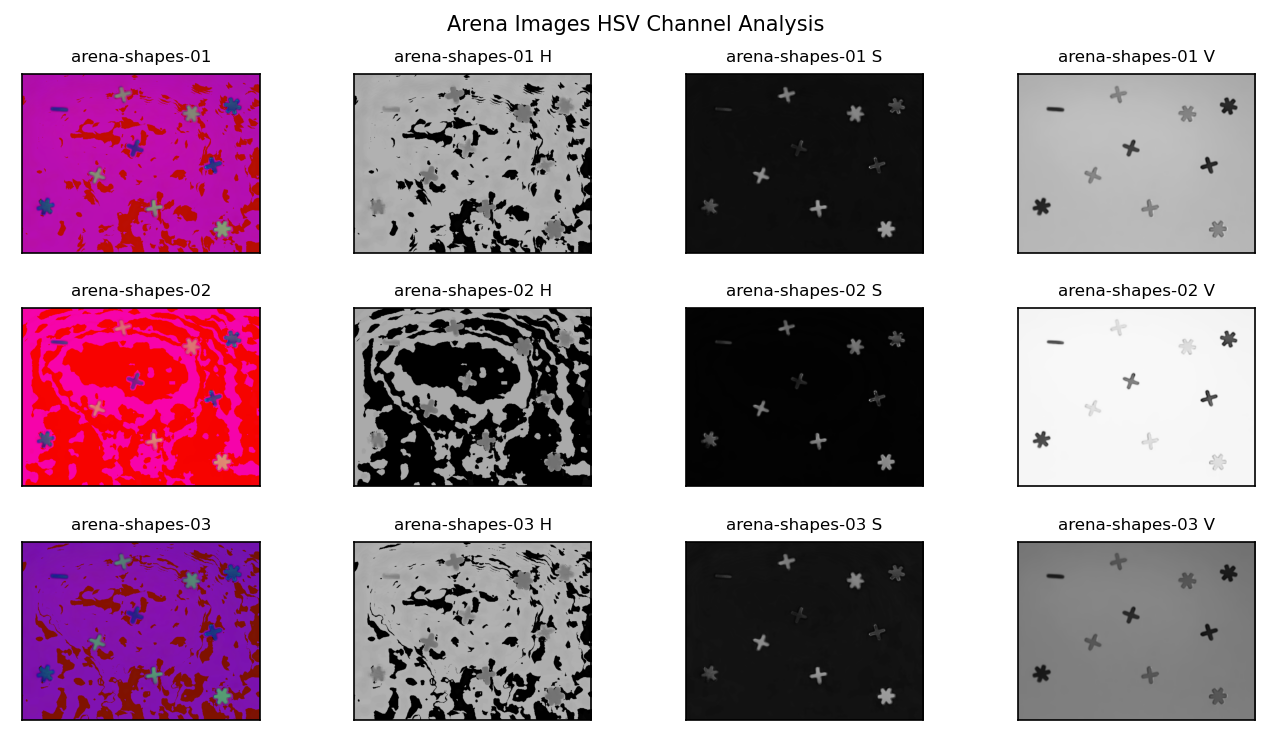

In [23]:
#Imagen original Seguida de un canal
arena_images_str=[]
arena_images=[]

for image, im_name in zip(images, im_names):
    image=cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    arena_images.append(image)
    arena_images_str.append(im_name)
    arena_images.append(image[:,:,0])
    arena_images_str.append(f"{im_name} H")
    arena_images.append(image[:,:,1])
    arena_images_str.append(f"{im_name} S")
    arena_images.append(image[:,:,2])
    arena_images_str.append(f"{im_name} V")


fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(arena_images)):
    fig.add_subplot(3,4,i+1)
    plt.imshow(cv2.cvtColor(arena_images[i], cv2.COLOR_BGR2RGB),'gray',vmin=0,vmax=255)
    plt.title(arena_images_str[i], fontsize=8)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Arena Images HSV Channel Analysis', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.savefig("results/Ex2.1-Arena-Images-HSV-Channel-Analysis.png",bbox_inches='tight')
plt.show()

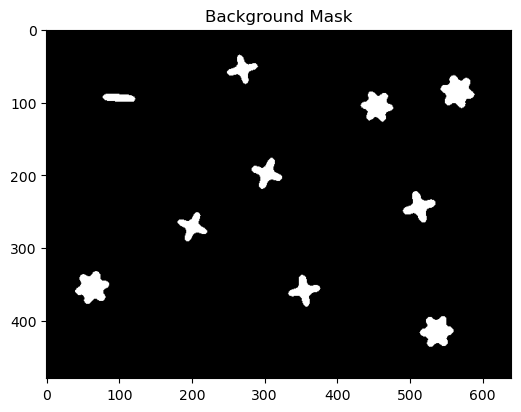

In [24]:
background_mask=cv2.medianBlur(cv2.bitwise_not(region_growing(arena_images_rgb[6], (0, 0), 0.2)), 9)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(background_mask, cmap='gray')
ax.set_title(f'Background Mask')
fig.savefig("results/Ex2.1-Background-Mask.png",bbox_inches='tight')
plt.show()

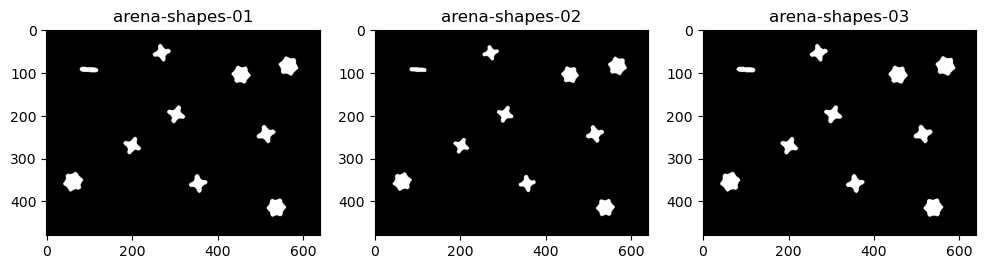

In [25]:
background_masks=[cv2.medianBlur(
    cv2.bitwise_not(region_growing(image, (0, 0), 0.2)), 13) for image in 
    [arena_images_rgb[2], arena_images_rgb[6], arena_images_rgb[10]]]
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), background_masks, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(nm)
plt.show()

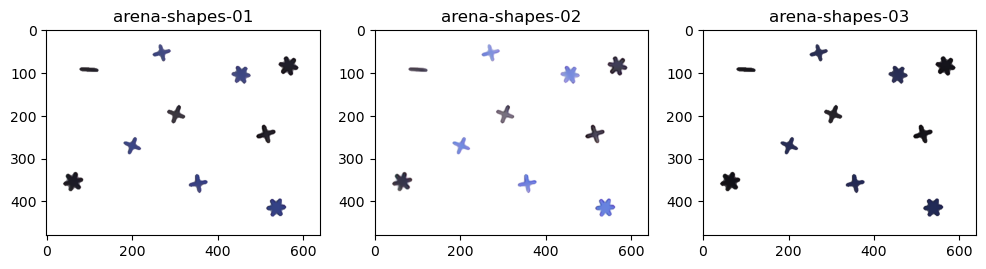

In [26]:
masked_images=[image.copy() for image in images]
for i in range(len(masked_images)):
    masked_images[i][background_mask<255]=255
    
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), masked_images, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(nm)
plt.show()

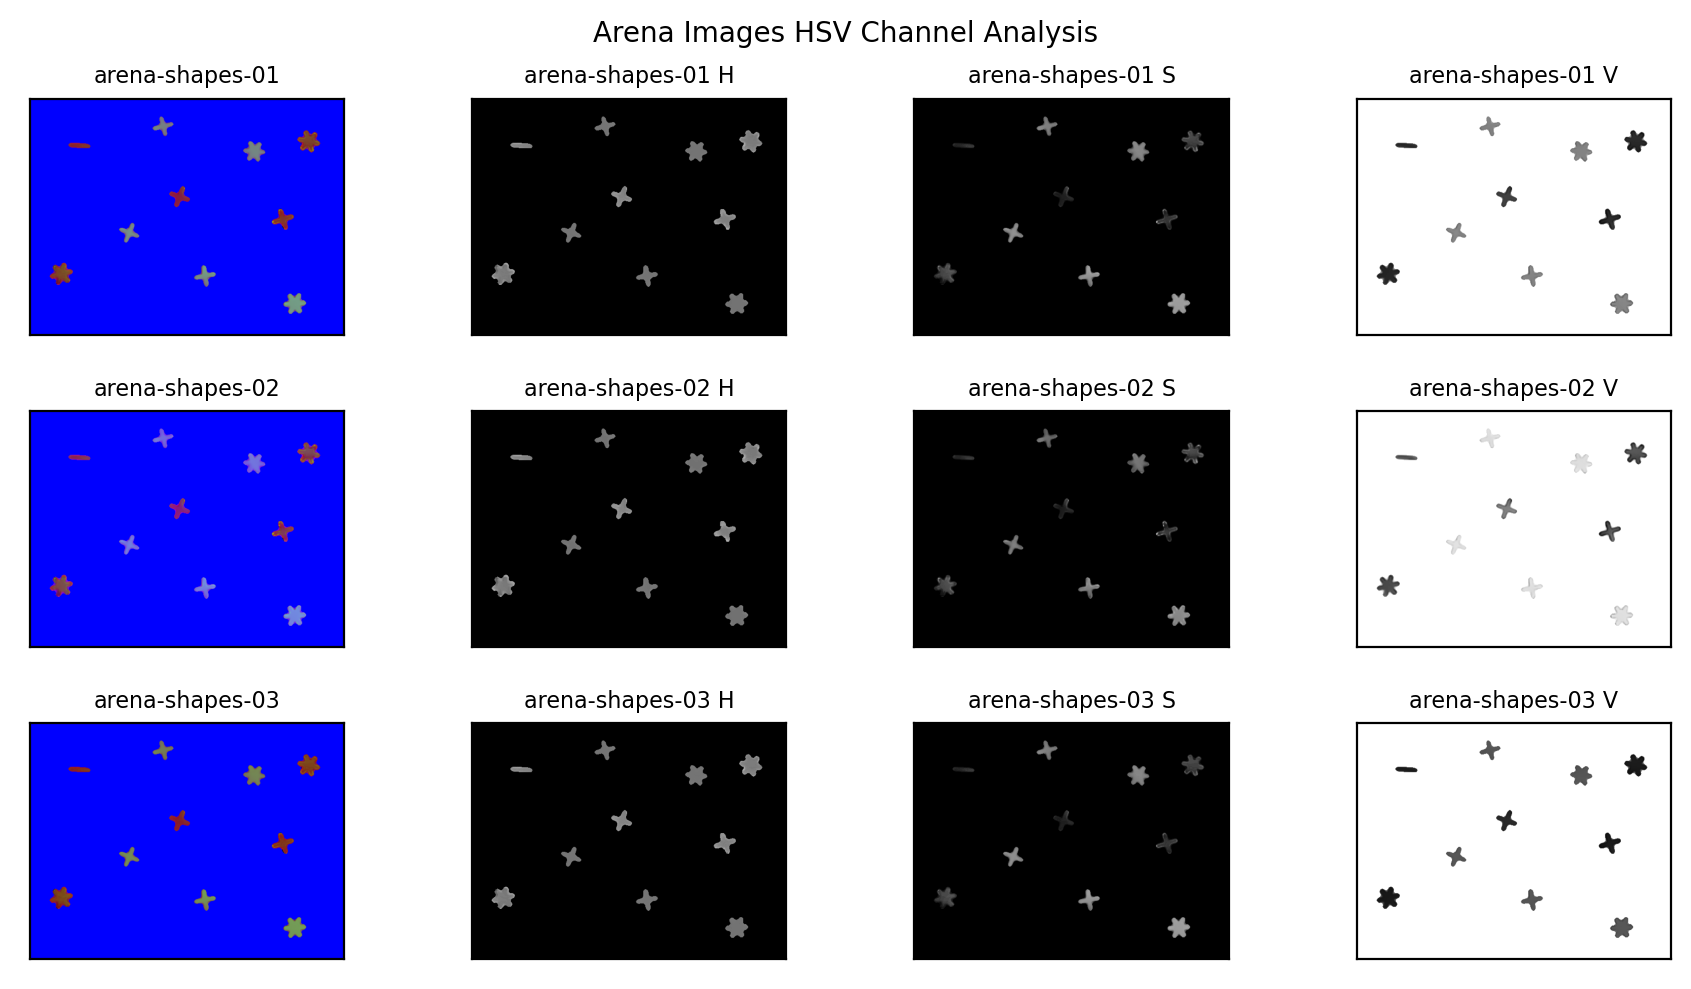

In [27]:
#Imagen original Seguida de un canal
arena_images_str=[]
arena_images=[]

for image, im_name in zip(masked_images, im_names):
    image=cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    arena_images.append(image)
    arena_images_str.append(im_name)
    arena_images.append(image[:,:,0])
    arena_images_str.append(f"{im_name} H")
    arena_images.append(image[:,:,1])
    arena_images_str.append(f"{im_name} S")
    arena_images.append(image[:,:,2])
    arena_images_str.append(f"{im_name} V")


fig=plt.figure(figsize=(9,5), dpi=200)
for i in range(len(arena_images)):
    fig.add_subplot(3,4,i+1)
    plt.imshow(arena_images[i],'gray',vmin=0,vmax=255)
    plt.title(arena_images_str[i], fontsize=8)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Arena Images HSV Channel Analysis', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.savefig("results/Ex2.1-Masked-Arena-Images-HSV-Channel-Analysis.png",bbox_inches='tight')
plt.show()

In [28]:
im2process=[arena_images[1], arena_images[5], arena_images[9]]

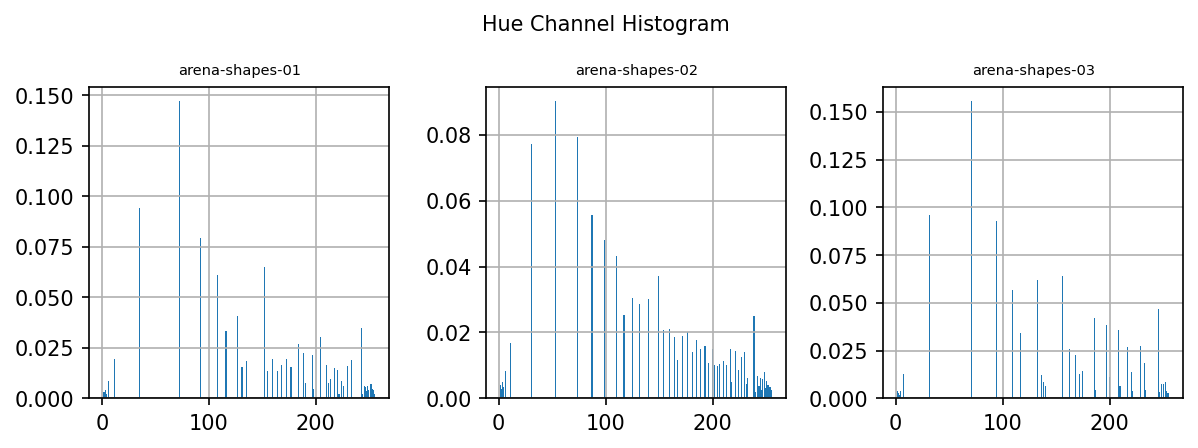

In [29]:
fig=plt.figure(figsize=(8,3), dpi=150)
for i in range(len(im2process)):
    fig.add_subplot(1,3,i+1)
    plt.hist(cv2.equalizeHist(im2process[i].ravel()),256,[1,256], density=1)
    plt.grid()
    plt.title(im_names[i], fontsize=7)
fig.suptitle('Hue Channel Histogram', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.82)
plt.show()

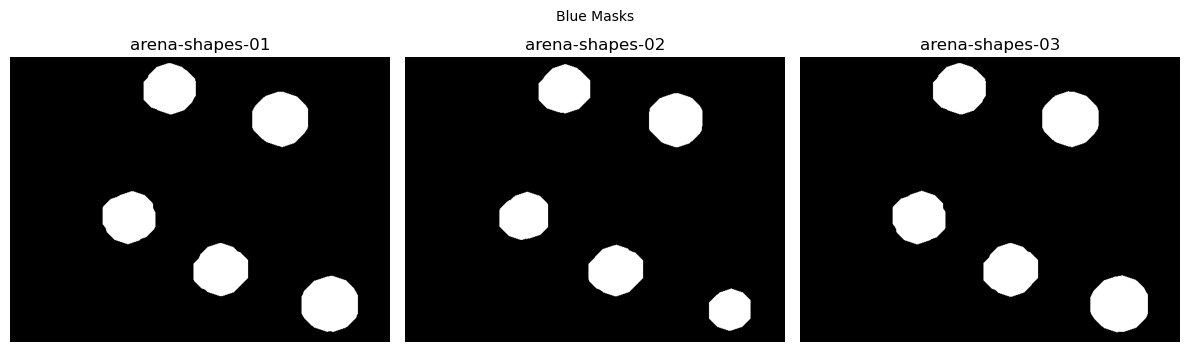

In [30]:
blue_masks=[cv2.dilate(cv2.medianBlur(cv2.inRange(image, 114, 119), 15), 
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations=6) for  image in im2process]

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), blue_masks, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('Blue Masks', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=1.63)
fig.savefig("results/Ex2.1-Blue-Masks.png",bbox_inches='tight')
plt.show()

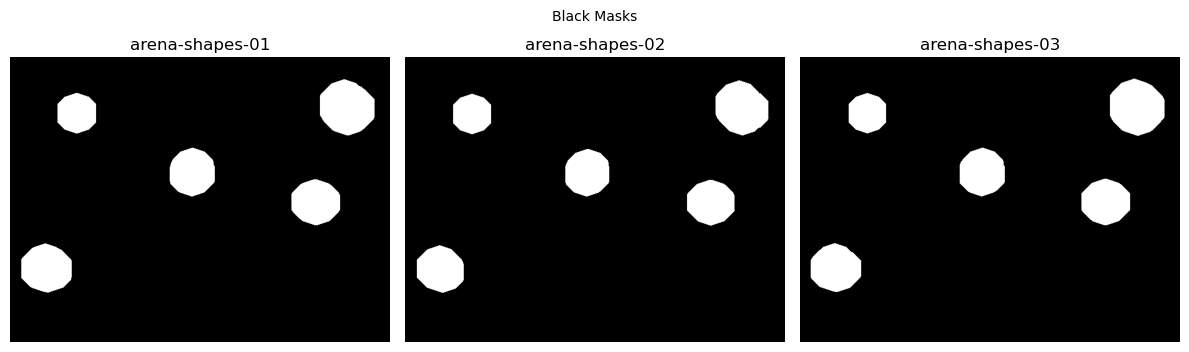

In [31]:
black_masks=[cv2.dilate(cv2.medianBlur(cv2.inRange(image, 123, 135), 15), 
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations=6) for  image in im2process]

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), black_masks, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('Black Masks', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=1.63)
fig.savefig("results/Ex2.1-Black-Masks.png",bbox_inches='tight')
plt.show()

El número de figuras azules es de 5 y el número de figuras negras es de 5
El area de las figuras azules es 4184.5 pixeles y el areas de las figuras negras es 4297.5 pixeles.
El número de figuras azules es de 5 y el número de figuras negras es de 5
El area de las figuras azules es 4167.0 pixeles y el areas de las figuras negras es 4291.0 pixeles.
El número de figuras azules es de 5 y el número de figuras negras es de 5
El area de las figuras azules es 4184.5 pixeles y el areas de las figuras negras es 4283.5 pixeles.


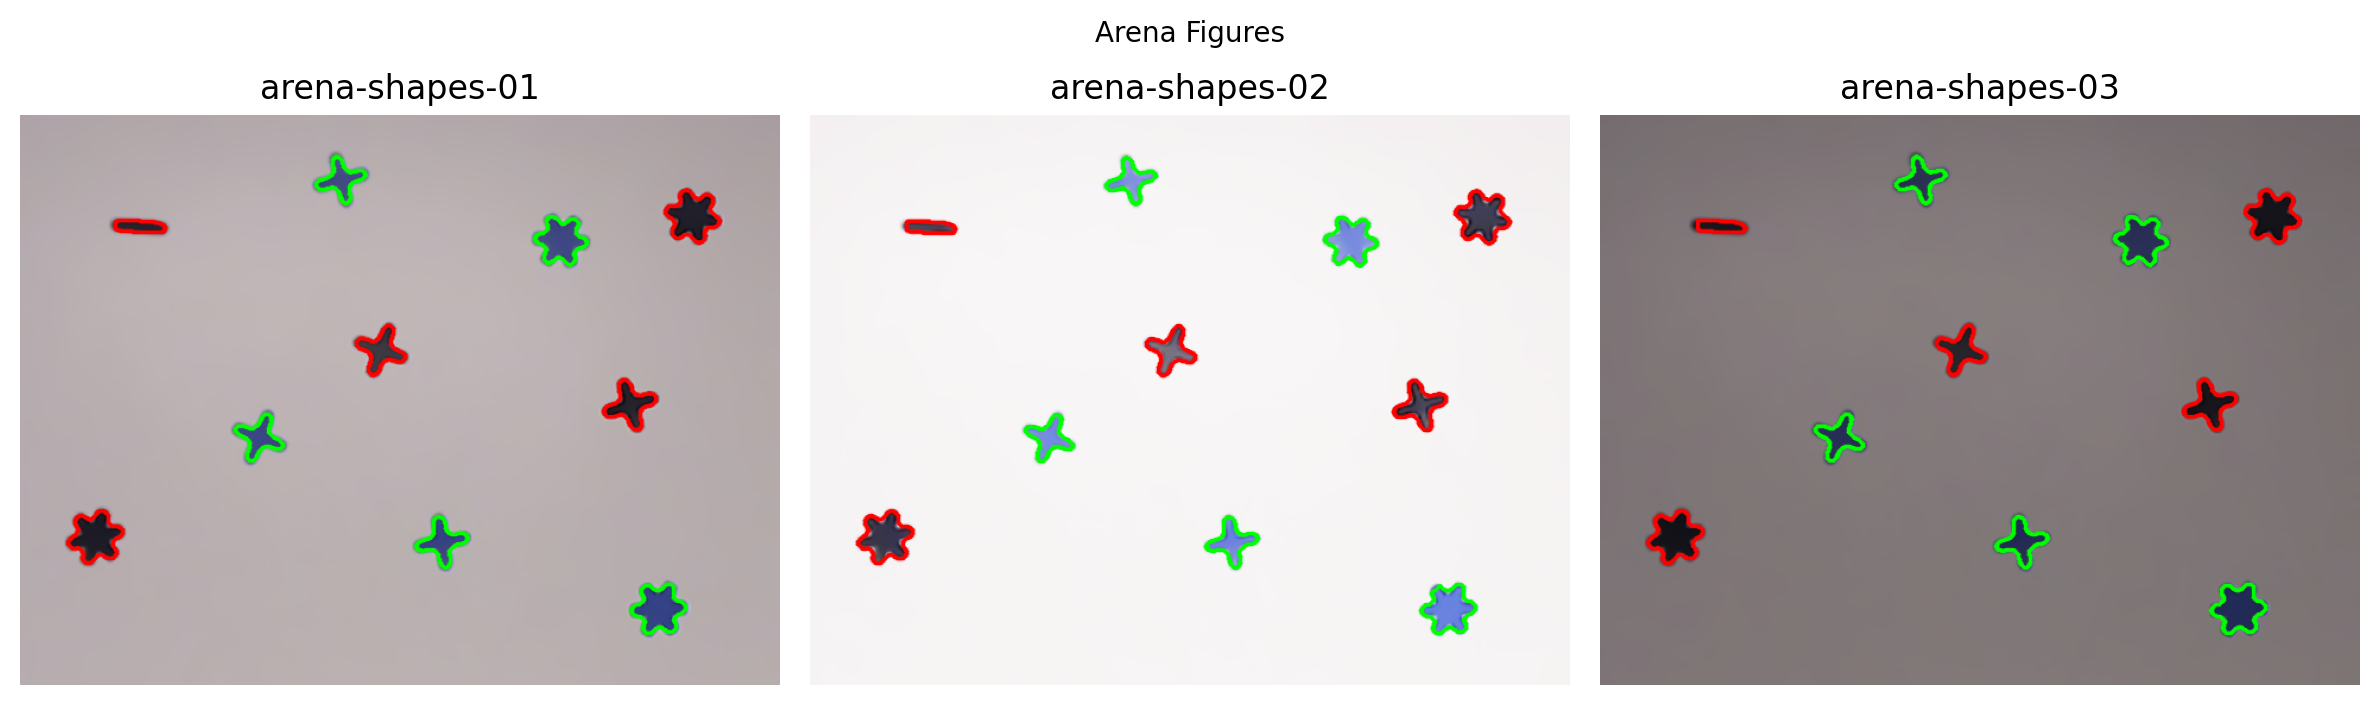

In [32]:
output_images=[image.copy() for image in images]
for out_img, blue_mask, black_mask in zip(output_images, blue_masks, black_masks):
 
    area=0
    in_img=background_mask.copy()
    in_img[blue_mask<255]=0
    blue_contours, hierarchy = cv2.findContours(image=in_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image=out_img, contours=blue_contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    in_img=background_mask.copy()
    in_img[black_mask<255]=0
    black_contours, hierarchy = cv2.findContours(image=in_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image=out_img, contours=black_contours, contourIdx=-1, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    blue_figures=len(blue_contours)
    blue_area=0
    for countour in blue_contours:
        blue_area+=cv2.contourArea(countour)

    black_figures=len(black_contours)
    black_area=0
    for countour in black_contours:
        black_area+=cv2.contourArea(countour)

    print(f'El número de figuras azules es de {blue_figures} y el número de figuras negras es de {black_figures}')
    print(f'El area de las figuras azules es {blue_area} pixeles y el areas de las figuras negras es {black_area} pixeles.')
    

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12), dpi=200)
for ax, im, nm in zip(axes.ravel(), output_images, im_names):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('Arena Figures', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=1.63)
fig.savefig("results/Ex2.1-Identified-Arena-Figures-Tets.png",bbox_inches='tight')
plt.show()

## 2.2 Numero de formas (shapes) de cada color (5 pts)

In [33]:
def get_shapes(image):
    """
    Detects blue and black shapes in an input image using 
    computer vision techniques and returns the count of each shape.

    Parameters:
    image (numpy.ndarray): An input image in the BGR color space.

    Returns:
    tuple: A tuple containing the count of black shapes, 
    count of blue shapes, and a copy of the input image 
    with detected shapes outlined in green (RGB color space).
    """
    
    # create a copy of the input image
    output_image = image.copy()

    # apply non-local means denoising to the image
    image = cv2.fastNlMeansDenoising(image, templateWindowSize=7, searchWindowSize=21, h=10)

    # convert the image to the RGB color space and extract the green channel
    image_green =  cv2.bilateralFilter(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:,1],9,25,25)

    # perform region growing to segment the background from the foreground
    background_mask = cv2.medianBlur(cv2.bitwise_not(
        region_growing(image_green, (0, 0), 0.2)), 9)

    # set pixels in the input image that correspond to the background to white
    masked_image = image.copy()
    masked_image[background_mask<255] = 255

    # extract the hue channel from the masked image
    image_hue = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)[:,:,0]

    # create a binary mask for blue shapes and dilate it to fill gaps
    blue_mask = cv2.dilate(cv2.medianBlur(cv2.inRange(image_hue, 114, 119), 15), 
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations=6)

    # create a binary mask for black shapes and dilate it to fill gaps
    black_mask = cv2.dilate(cv2.medianBlur(cv2.inRange(image_hue, 123, 135), 15), 
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations=6)

    # create a copy of the background mask
    in_img = background_mask.copy()

    # set pixels in the input image that correspond to blue shapes to black and find contours
    in_img[blue_mask<255] = 0
    blue_contours, hierarchy = cv2.findContours(
        image=in_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

    # draw the blue contours on the output image
    cv2.drawContours(image=output_image, contours=blue_contours, contourIdx=-1, 
        color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    # create a copy of the background mask
    in_img = background_mask.copy()

    # set pixels in the input image that correspond to black shapes to black and find contours
    in_img[black_mask<255] = 0
    black_contours, hierarchy = cv2.findContours(
        image=in_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

    # draw the black contours on the output image
    cv2.drawContours(image=output_image, contours=black_contours, 
        contourIdx=-1, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
    
    # count the number of blue and black contours
    blue_figures = len(blue_contours)
    black_figures = len(black_contours)

    # return the count of black and blue shapes and the output image in the RGB color space
    return (black_figures, blue_figures, cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)) 

Numero de formas negras: 5 & Numero de formas azules: 5
Numero de formas negras: 5 & Numero de formas azules: 5
Numero de formas negras: 5 & Numero de formas azules: 5


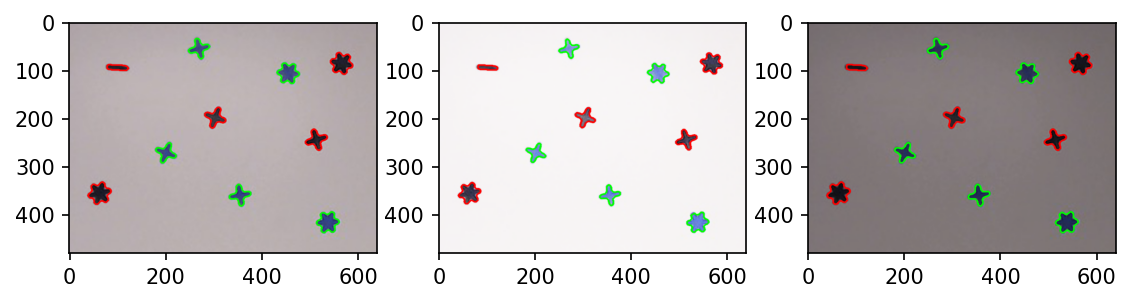

In [34]:
fig=plt.figure(figsize=(9,5), dpi=150)
for i, filename in enumerate(filenames):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    print(f'Numero de formas negras: {get_shapes(img)[0]} & Numero de formas azules: {get_shapes(img)[1]}')
    # Plot images
    fig.add_subplot(1,3,i+1)
    plt.imshow(get_shapes(img)[2],'gray',vmin=0,vmax=255)

fig.savefig("results/Ex2.2-Identified-Arena-Figures.png",bbox_inches='tight')

## 2.3 Area total (en pixeles) de cada color (5 pts)

In [35]:
def get_area(image):
    """
    Calculate the area of black and blue shapes in an input image.
    
    This function applies non-local means denoising and region growing techniques 
    to segment the foreground from the background in the input image. It then creates 
    binary masks for blue and black shapes and calculates the area of each shape.
    
    Args:
        image: An input image as a numpy array.
        
    Returns:
        A tuple containing the areas of the black and blue shapes in the input image.
    """

    # create a copy of the input image
    output_image = image.copy()

    # apply non-local means denoising to the image
    image = cv2.fastNlMeansDenoising(image, templateWindowSize=7, searchWindowSize=21, h=10)

    # convert the image to the RGB color space and extract the green channel
    image_green =  cv2.bilateralFilter(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:,1],9,25,25)

    # perform region growing to segment the background from the foreground
    background_mask = cv2.medianBlur(cv2.bitwise_not(
        region_growing(image_green, (0, 0), 0.2)), 9)

    # set pixels in the input image that correspond to the background to white
    masked_image = image.copy()
    masked_image[background_mask<255] = 255

    # extract the hue channel from the masked image
    image_hue = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)[:,:,0]

    # create a binary mask for blue shapes and dilate it to fill gaps
    blue_mask = cv2.dilate(cv2.medianBlur(cv2.inRange(image_hue, 114, 119), 15), 
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(17,17)), iterations=7)

    # create a binary mask for black shapes and dilate it to fill gaps
    black_mask = cv2.dilate(cv2.medianBlur(cv2.inRange(image_hue, 123, 135), 15), 
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(17,17)), iterations=7)

    black_area=np.sum(cv2.medianBlur(background_mask-blue_mask, 7)> 150)
    blue_area=np.sum(cv2.medianBlur(background_mask-black_mask, 7)> 150)

    return (black_area, blue_area) 
    

Area de formas negras: 4971 & Area de formas azules: 5110
Area de formas negras: 4401 & Area de formas azules: 4394
Area de formas negras: 5028 & Area de formas azules: 5204


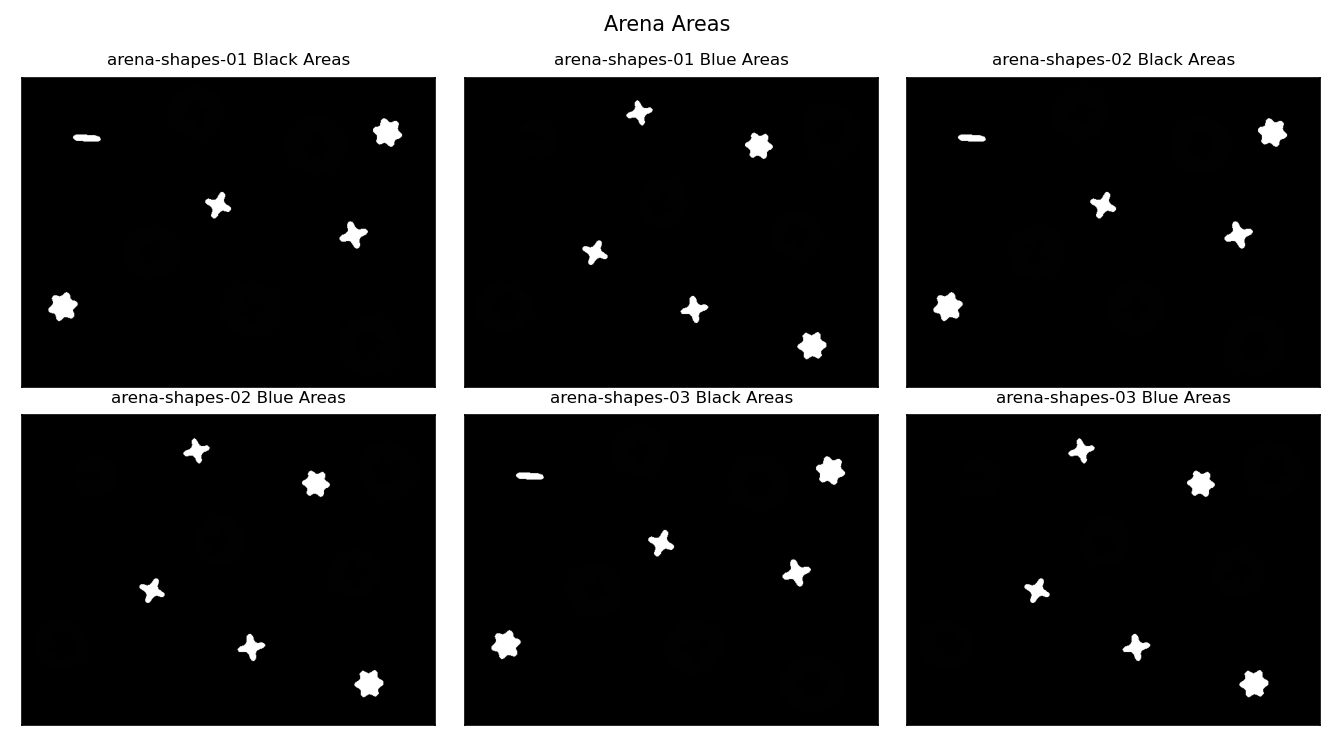

In [36]:
tmp=[]
tmp_str=[]
for i, filename in enumerate(filenames):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    print(f'Area de formas negras: {get_area(img)[0]} & Area de formas azules: {get_area(img)[1]}')
    fig.add_subplot(2,3,i+1)
    tmp.append(cv2.medianBlur(background_mask-blue_mask,7))
    tmp_str.append(f"{im_names[i]} Black Areas")
    tmp.append(cv2.medianBlur(background_mask-black_mask,7))
    tmp_str.append(f"{im_names[i]} Blue Areas")

fig=plt.figure(figsize=(9,5), dpi=150)
for i in range(len(tmp)):
    fig.add_subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(tmp[i], cv2.COLOR_BGR2RGB),'gray',vmin=0,vmax=255)
    plt.title(tmp_str[i], fontsize=8)
    plt.xticks([]),plt.yticks([])
fig.suptitle('Arena Areas', fontsize=10)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.savefig("results/Ex2.3-Counted-Arena-Areas.png",bbox_inches='tight')
plt.show()